In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from functools import partial 
np.random.seed(0)

In [2]:
T = 1000
N = 3
d = 4
mu_noise_level = 0.5
reward_noise_level = 0.1
n_mc_runs = 4

mu_true = np.random.randn(N,d)
def mu_noise(d,mu_noise_level=0.5):
    return mu_noise_level*np.random.randn(d)
def reward_noise(reward_noise_level=0.1):
    return reward_noise_level*np.random.randn()
mu_estimated = np.zeros_like(mu_true)

In [3]:
def get_choice_myopic(context,mu_x,payments=None):
    temp = np.dot(mu_x,context)
    if payments is not None:
        temp += payments
    return temp.argmax()

In [4]:
def get_context_v1(d):
    return np.random.randn(d)

def get_payments_v1(context,contexts,mu_realizations,t,T,N,mu_estimated):
    return None

In [5]:
def interactions(get_context,get_payments):

    #Initial N rounds are free
    for t in range(N):
        mu_estimated[t] = mu_true[t] + mu_noise(d,mu_noise_level)

    #variables for logging
    pseudoregret_inst = np.zeros(T)
    contexts = {}
    mu_realizations = {}

    #T interactions
    for t in range(T):
        #agent arrives
        context = get_context(d)

        #platform decides to pay
        payments = get_payments(context,contexts,mu_realizations,t,T,N,mu_estimated)

        #agent decides arm
        choice = get_choice_myopic(context,mu_estimated,payments)

        #Platform updates estimates
        mu_realized = mu_true[choice] + mu_noise(d,mu_noise_level)
        mu_estimated[choice] = (t*mu_estimated[choice] + mu_realized)/(t+1)
        reward_realized = np.dot(mu_true[choice],context) + reward_noise()

        #Regret computation
        opt_choice = get_choice_myopic(context,mu_true,None)
        pseudoregret_inst[t] = np.dot(mu_true[opt_choice],context) - np.dot(mu_true[choice],context)

        #History
        contexts[t] = context
        mu_realizations[t] = {'choice':choice,'mu_realized':mu_realized}

    pseudoregret = np.cumsum(pseudoregret_inst)
    return pseudoregret

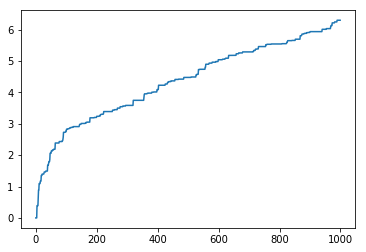

In [6]:
prs1 = np.zeros((n_mc_runs,T))
for mc_run in range(n_mc_runs):
    prs1[mc_run] = interactions(get_context=get_context_v1,get_payments = get_payments_v1)

plt.plot(np.mean(prs1,axis=0))
plt.show()

In [7]:
def get_mean_cov():
    mean = np.ones(d)
    cov0 = 0.1*np.random.randn(d,d)
    cov = np.ones((d,d)) + np.dot(cov0,cov0.transpose())
    return mean, cov

def get_context_v2_full(mean,cov,d):
    return np.random.multivariate_normal(mean, cov)

c2mean,c2cov = get_mean_cov()
get_context_v2 = partial(get_context_v2_full,c2mean,c2cov) 

def get_payments_v2(context,contexts,mu_realizations,t,T,N,mu_estimated):
    
    #count of arm pulls
    arm_pulls = np.zeros(N)
    for x in mu_realizations:
        arm_pulls[mu_realizations[x]['choice']] += 1
    
    #phase estimate
    s = arm_pulls.min()+1 #plus 1 because of the initial N pulls
    
    #debug
    # print('mu_realizations',mu_realizations)
    # print('state',s)

    #payment eligible arm estimation
    phivec = np.zeros(N)
    for i in range(N):
        for k in contexts:
            constraint_holds = True
            for j in range(N):
                if i != j:
                    if np.dot(contexts[k],mu_estimated[i]-mu_estimated[j]) <= 0:
                        constraint_holds = False
            if constraint_holds == True:
                phivec[i] += 1
    phivec = phivec/phivec.sum()            
    
    if phivec.min() > 1/np.log(s+1e-6):
        return None #no payment
    else:
        #estimating payment amount
        peligible_arm = phivec.argmin()
        
        largest = 0
        for i in range(N):
            if i != peligible_arm:
                temp = np.dot(context,mu_estimated[i] - mu_estimated[peligible_arm])
                if temp > largest:
                    largest = temp

        payment = np.zeros(N)
        payment[peligible_arm] = largest
#         print('t',t,'payment',largest)
        return payment
    

/home/theja/local/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


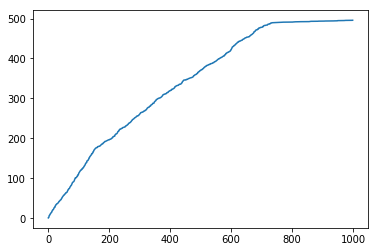

In [8]:

prs2 = np.zeros((n_mc_runs,T))
for mc_run in range(n_mc_runs):
    prs2[mc_run] = interactions(get_context=get_context_v1,get_payments = get_payments_v2)

plt.plot(np.mean(prs2,axis=0))
plt.show()

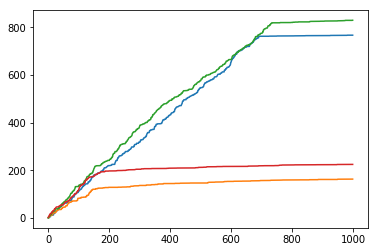

In [10]:
plt.plot(prs2.T)

/home/theja/local/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


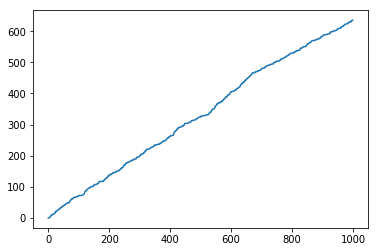

In [11]:
prs2 = np.zeros((n_mc_runs,T))
for mc_run in range(n_mc_runs):
    prs2[mc_run] = interactions(get_context=get_context_v2,get_payments = get_payments_v2)

plt.plot(np.mean(prs2,axis=0))
plt.show()

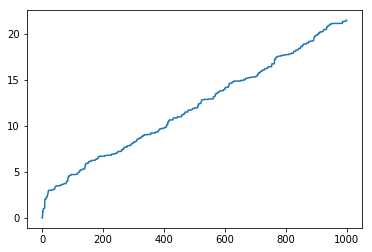

In [12]:
prs2 = np.zeros((n_mc_runs,T))
for mc_run in range(n_mc_runs):
    prs2[mc_run] = interactions(get_context=get_context_v2,get_payments = get_payments_v1)

plt.plot(np.mean(prs2,axis=0))
plt.show()